<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v11: Combining weights, gradients, and unit activity
I've now created separate utilities for collecting gradients, variables, and unit activation during training.

Now let's prove that they work together well and can be combined.
This will be a precursor to creating a utility for "explaining" near-zero gradients.

In [249]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout 704ef35
#!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at 704ef35 Added ability to estimate magnitudes in variable history plot
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 2.08 MiB | 2.39 MiB/s, done.
From https://github.com/malcolmlett/ml-learning
   704ef35..cd6cad6  main       -> origin/main
Note: switching to '704ef35'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at

<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [67]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [74]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


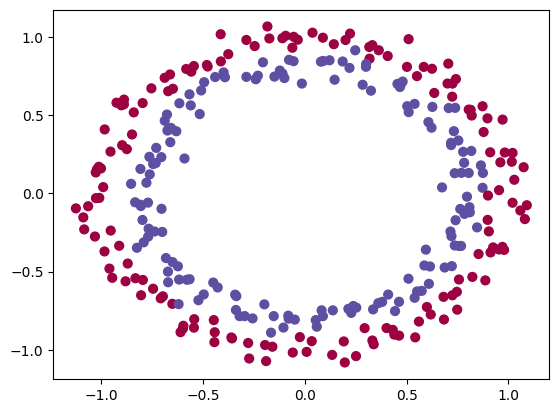

In [4]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [5]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

## Full data collection
First we'll train the model and collect all stats, plus collect detailed raw values for some selected layers.

Recall that we have the following basic API and that all of these data collection callbacks now need to consistently support this (with some variables between variable-based vs output-based callbacks):
```python
collection_sets = [
    {
      # one of:
      'layers': [Layer] # references to actual layers, OR
      'layer_indices': [int]  # list of layer indices, OR
      'layer_names': [string]  # list of layer names, OR
      'variable_indices': [int]  # list of variable indices according to model.variables, OR
      'trainable_variable_indices': [int]  # list of variable indices according to model.trainable_variables

      # one of (not actually implemented yet):
      'density': float, default: 1.0  # fraction of units to collect outputs from, automatically sliced, OR
      'max_units': int, default: None  # max number of units to collect outputs from, automatically sliced, OR
      'slices': [slice]  # slices to use for each selected variable
    }
]
```

In [226]:
reload(tot)
tf.config.run_functions_eagerly(False)

collection_sets = [{}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])

Epoch     1 - 5.80s/epoch: loss: 0.6694  
Epoch     2 - 641.70ms/epoch: loss: 0.6331  
Epoch     3 - 652.80ms/epoch: loss: 0.6431  
Epoch     4 - 641.40ms/epoch: loss: 0.6461  
Epoch     5 - 642.13ms/epoch: loss: 0.6412  
Epoch     6 - 642.55ms/epoch: loss: 0.6140  
Epoch     7 - 647.79ms/epoch: loss: 0.6089  
Epoch     8 - 634.95ms/epoch: loss: 0.6073  
Epoch     9 - 659.40ms/epoch: loss: 0.6018  
Epoch    10 - 658.76ms/epoch: loss: 0.6003  


In [227]:
# Validate that the callbacks all got the right things on the output
print("Variables callback:")
print(f"Iterations: {variables.epochs if hasattr(variables, 'epochs') else variables.steps}")
print(f"Model stats: {variables.model_stats.keys()} x {len(variables.model_stats[50])}")
print(f"Variable stats: {[variable_stat.shape if variable_stat is not None else None for variable_stat in variables.variable_stats]}: {variables.variable_stats[0].columns}")
print(f"callback.collected_variables:")
for var_idx, var_list in zip(variables.collected_variable_indices, variables.collected_variables):
  print(f"  variable {var_idx}: len={len(var_list)} x type={type(var_list[0])} x {var_list[0].shape}")

print()
print("Gradients callback:")
print(f"Iterations: {gradients.epochs if hasattr(gradients, 'epochs') else gradients.steps}")
print(f"Model stats: {gradients.model_stats.keys()} x {len(gradients.model_stats[50])}")
print(f"Variable stats: {[gradient_stat.shape if gradient_stat is not None else None for gradient_stat in gradients.gradient_stats]}: {gradients.gradient_stats[0].columns}")
print(f"callback.collected_gradients:")
for var_idx, var_list in zip(gradients.collected_gradient_indices, gradients.collected_gradients):
  print(f"  gradient {var_idx}: len={len(var_list)} x type={type(var_list[0])} x {var_list[0].shape}")


print()
print("Activity callback:")
print(f"Iterations: {activity.epochs if hasattr(activity, 'epochs') else activity.steps}")
print(f"Model stats: {activity.model_stats.keys()} x {len(activity.model_stats['mean_dead_rate'])}")
print(f"Layer stats: {[len(layer_stat) if layer_stat else None for layer_stat in activity.layer_stats]}: {activity.layer_stats[0].keys()} x {len(activity.layer_stats[0]['dead_rate'])}")
print(f"callback.collected_layer_outputs:")
for l_idx, output_list in zip(activity.collected_layer_output_indices, activity.collected_layer_outputs):
    print(f"  layer {l_idx}: len={len(output_list)} x type={type(output_list[0])} x {output_list[0].shape}")


Variables callback:
Iterations: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Model stats: Index([0, 25, 50, 75, 100], dtype='int64') x 100
Variable stats: [(100, 9), (100, 9), (100, 9), (100, 9), None, (100, 9), (100, 9), (100, 9), (100, 9), None, (100, 9), (100, 9), (100, 9), (100, 9), None, None, (100, 9), (100, 9), (100, 9), (100, 9)]: Index([0.0, 12.5, 25.0, 37.5, 50.0, 62.5, 75.0, 87.5, 100.0], dtype='float64')
callback.collected_variables:
  variable 0: len=100 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (2, 100)
  variable 1: len=100 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100,)
  variable 2: len=100 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100, 100)
  varia

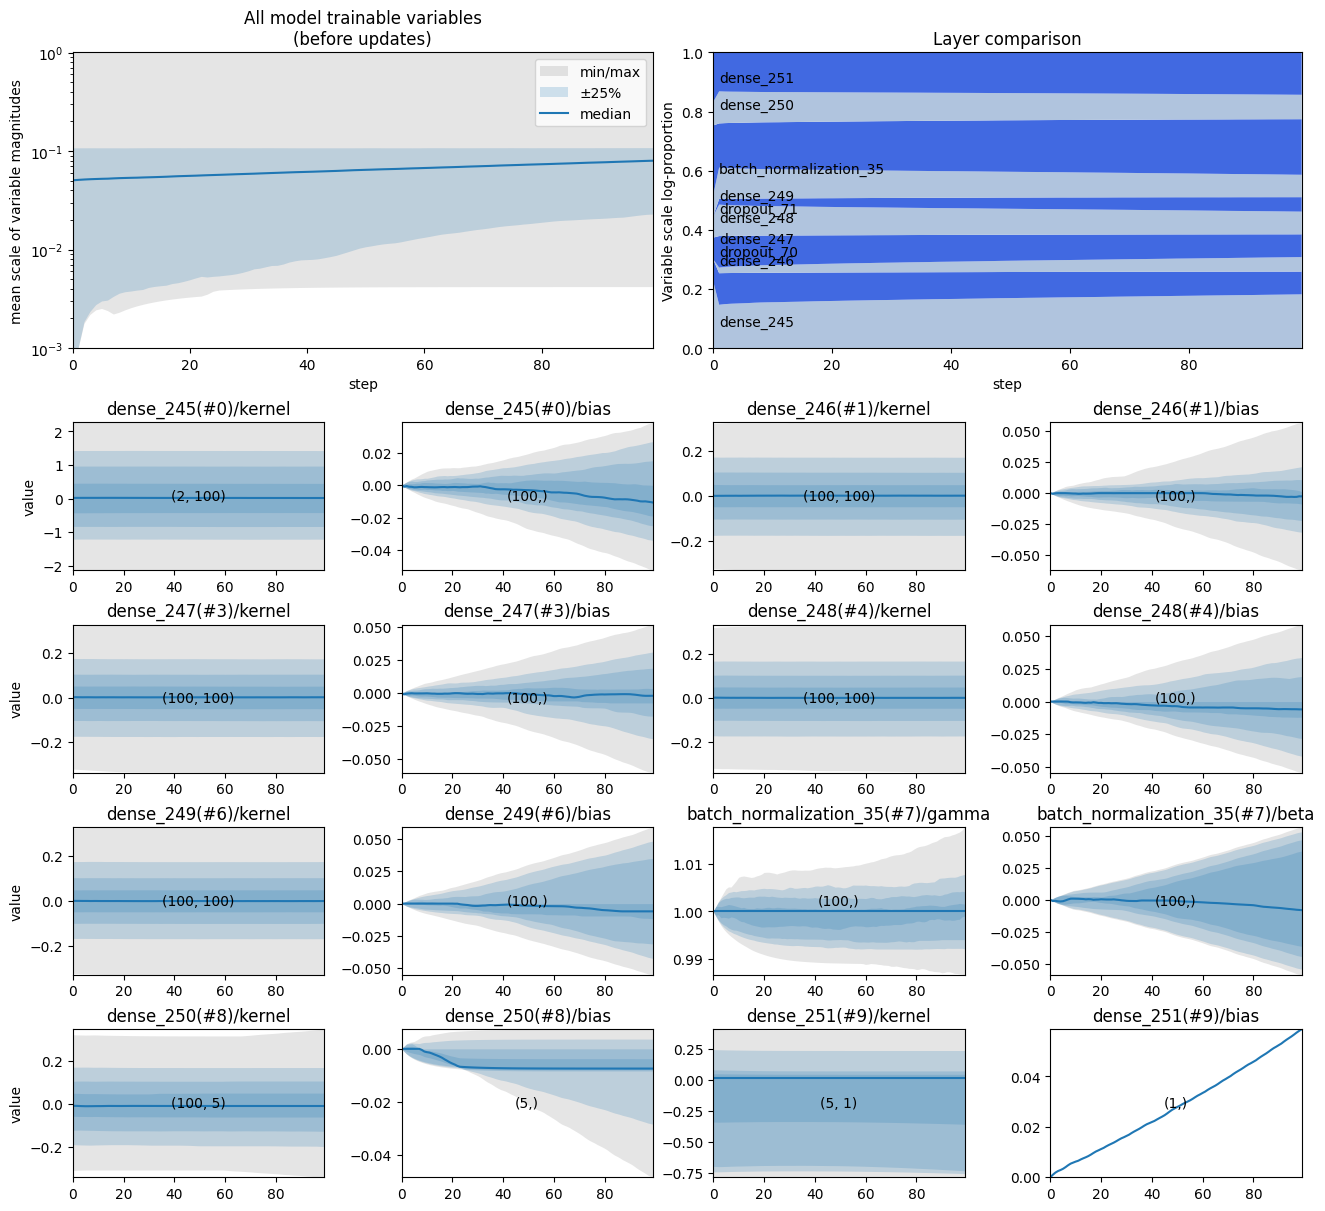

In [231]:
tot.plot_variable_history(variables)

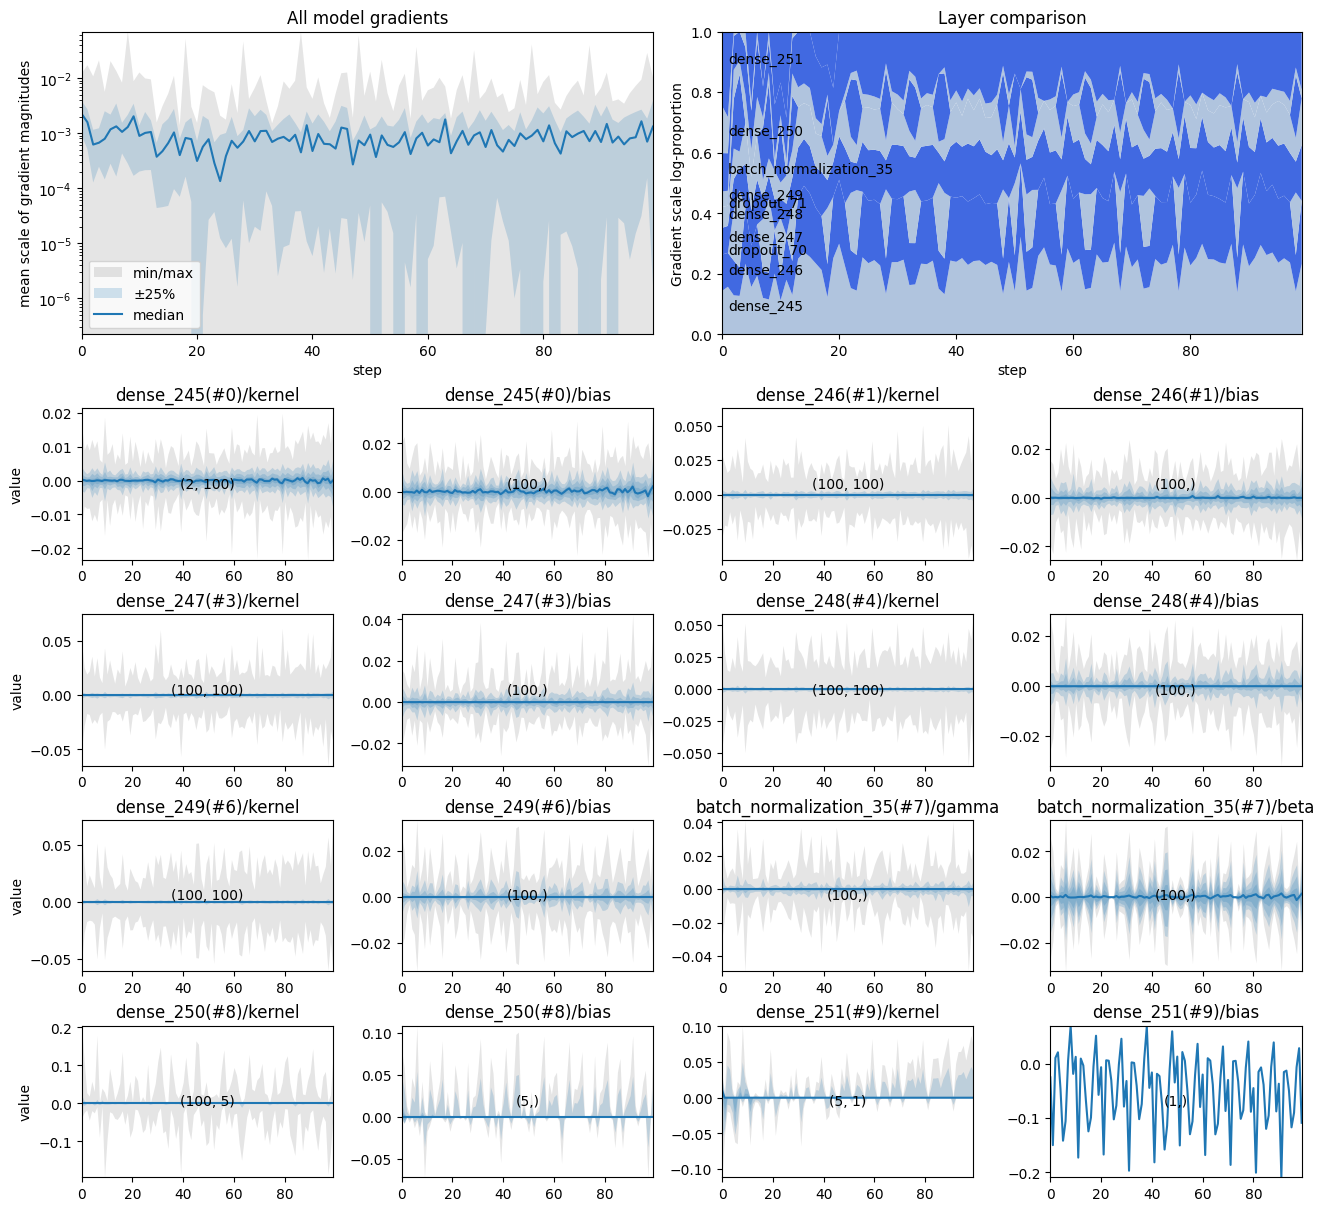

In [230]:
tot.plot_gradient_history(gradients)

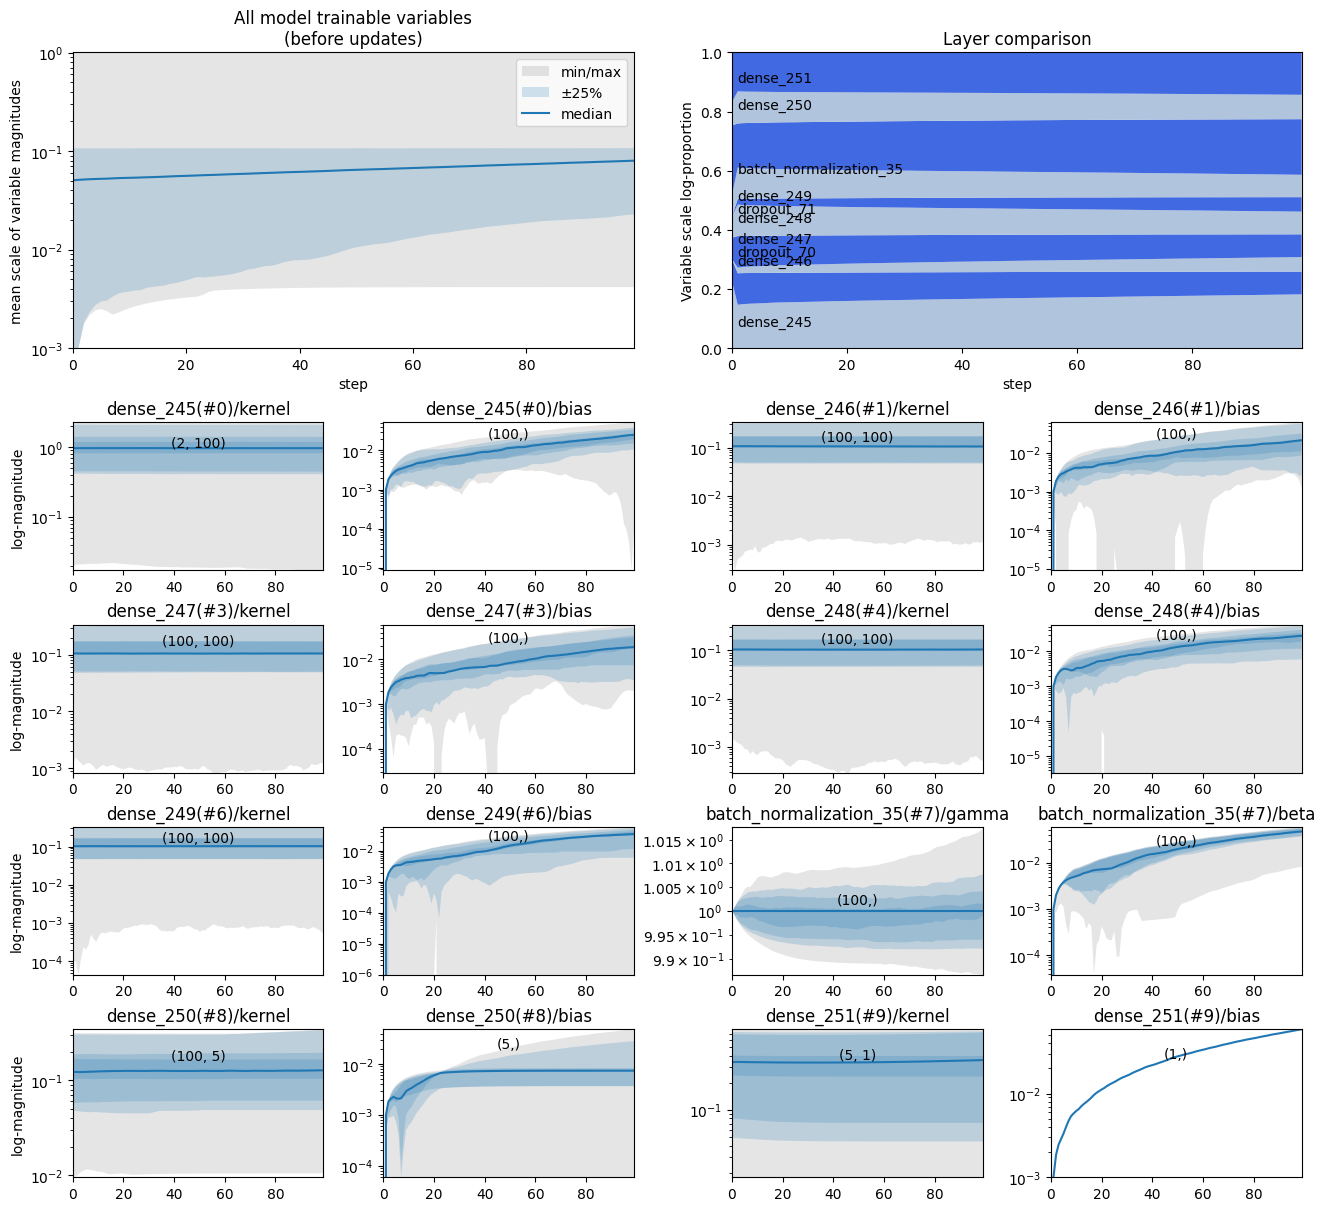

In [232]:
tot.plot_variable_history(variables, magnitudes=True)

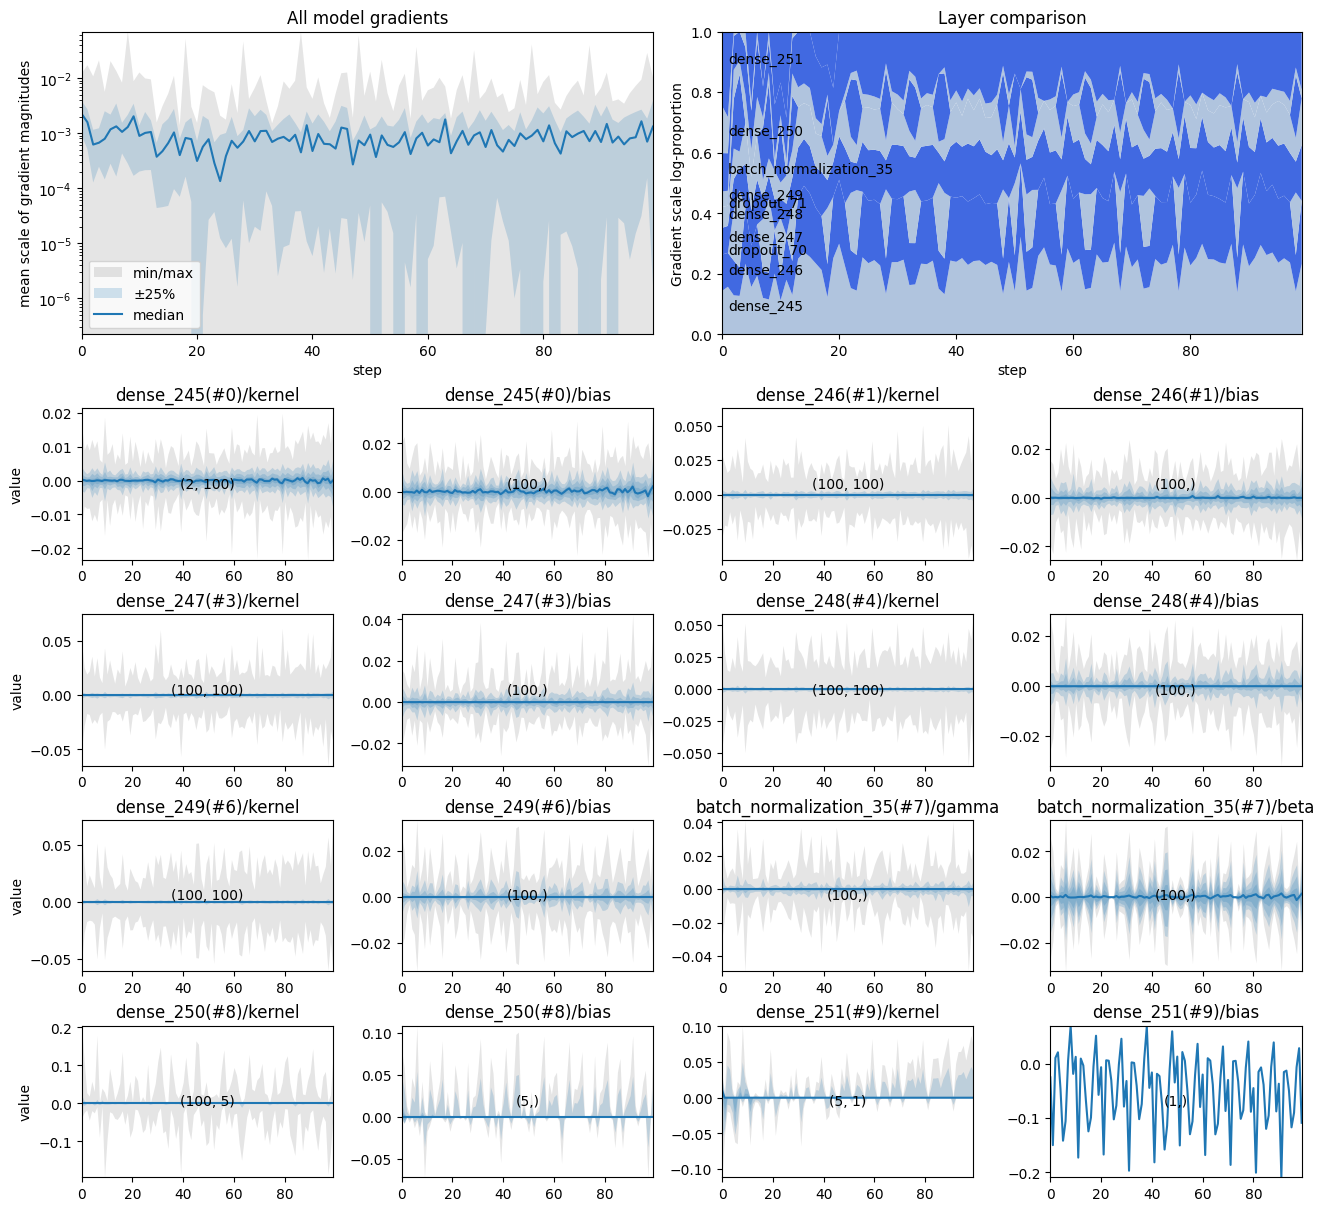

In [233]:
tot.plot_gradient_history(gradients)

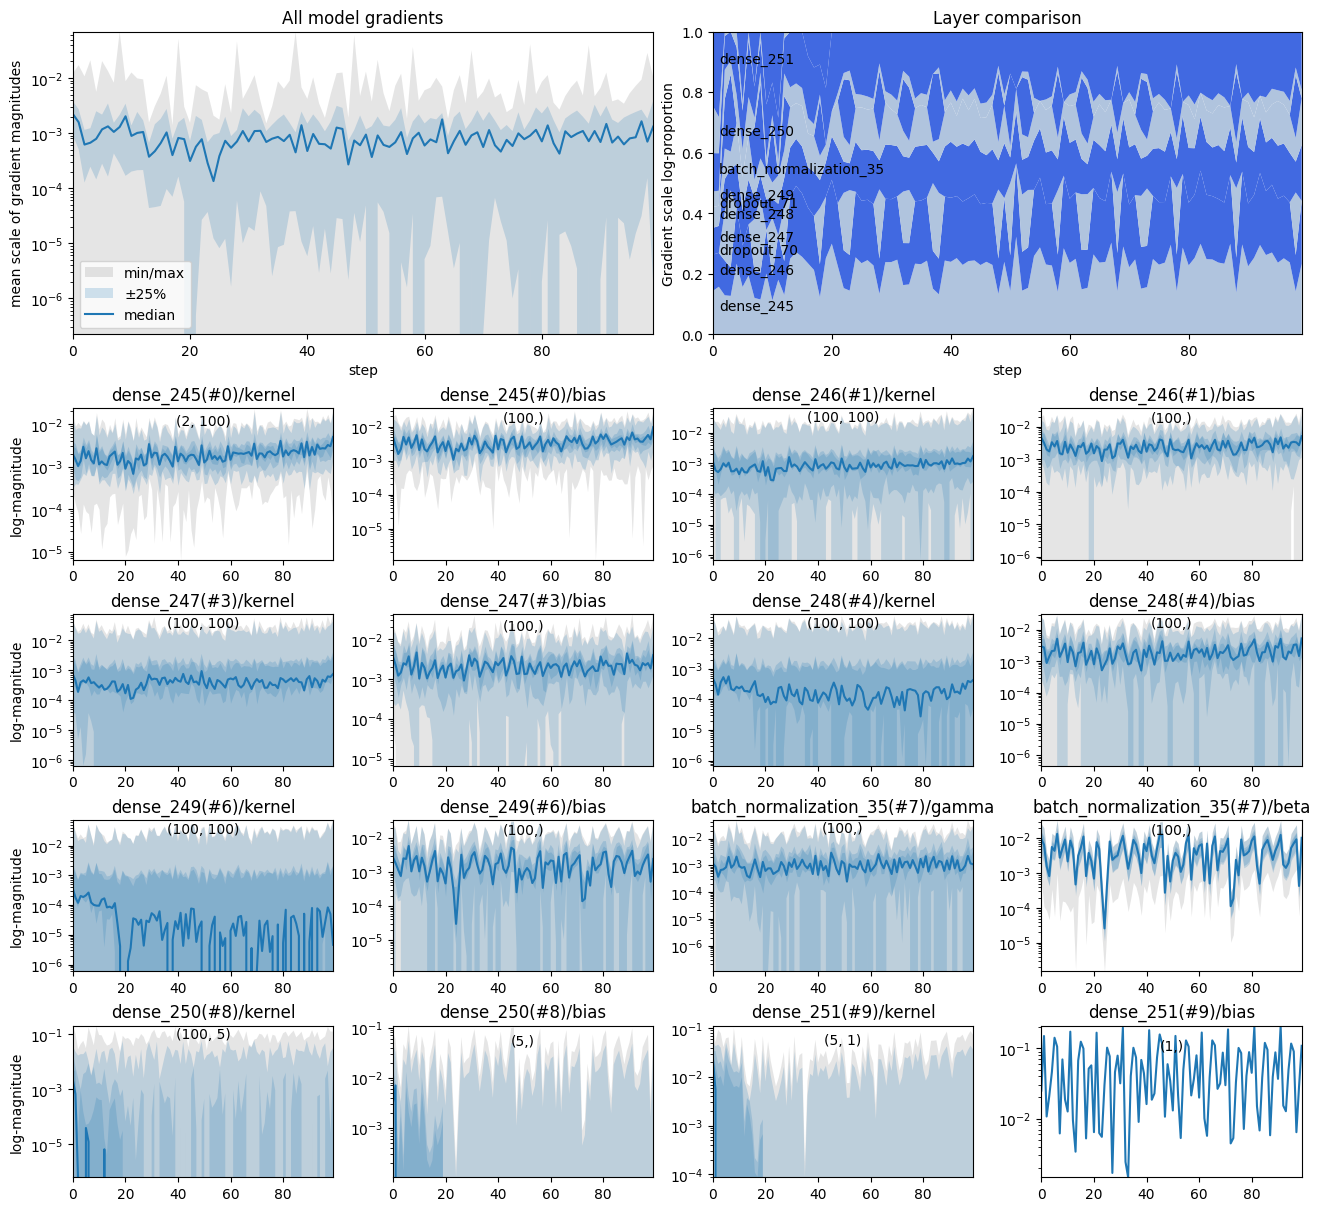

In [234]:
tot.plot_gradient_history(gradients, magnitudes=True)

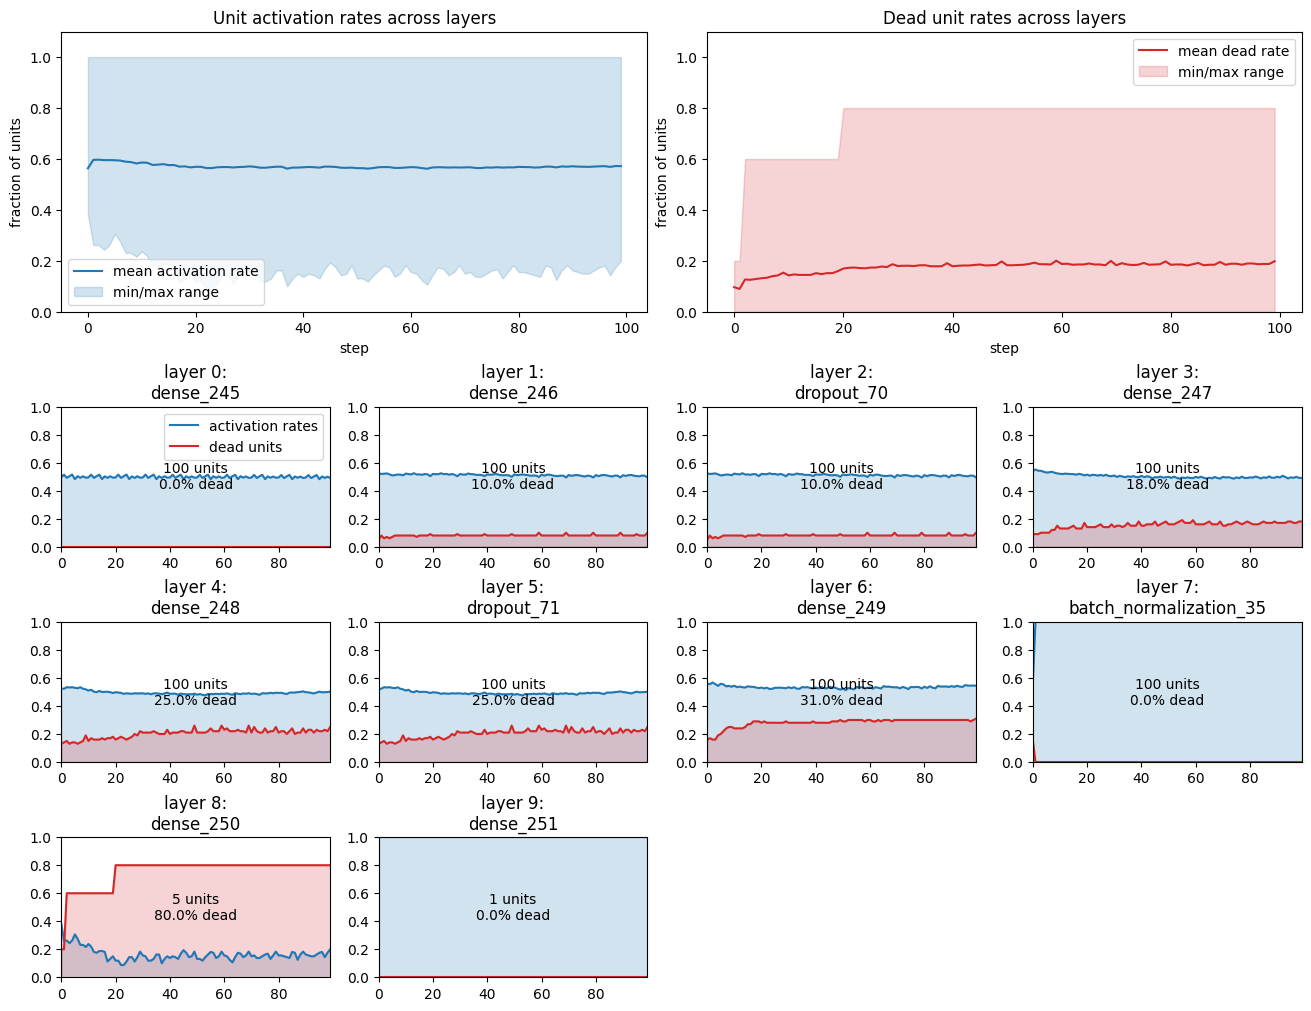

In [235]:
tot.plot_unit_activity(activity)

## Performance check
Before wrapping up. Let's check how badly the different callbacks affect training time.

Overall summary of results using eye-ball estimated mean per-epoch times against a range of scenarios involving all callbacks together:

|Setup|Mean per-epoch time|Total train time|
|---|---|---|
|Baseline default loop|40ms|11s|
|Baseline custom loop|35ms|8s|
|All callbacks, per-epoch, stats only|120ms|15s|
|All callbacks, per-epoch, data collection|120ms|15s|
|All callbacks, per-step, stats only|740ms|74s|
|All callbacks, per-step, data collection|800ms|85s|


Separately looking at the individual costs of the callbacks, when collecting per-step:

|Callback|data collection|Mean per-epoch time|Total train time|
|---|---|---|---|
|variables|false|320ms|39s|
|variables|true|400ms|42s|
|gradients|false|220ms|30s|
|gradients|true|250ms|29s|
|activity|false|170ms|22s|
|activity|true|200ms|22s|

Conclusions:
* Calculating percentiles across the variables/gradients is the most expensive computation (adding about 200 to 300ms per epoch).
* Collecting and storing raw variables/gradients/activities adds overhead but not so much (only about 50ms per epoch).
* The Activity callback doesn't currently compute percentiles and thus it is noticeably faster than the others. Though even its mean/std/min/max calculations appear to add considerable cost compared to collecting data data.
* Each callback has its own "slow-down" effect and they approximately sum when determining the total slow-down for the training loop

In [236]:
# Baseline - default training loop without any data collection callbacks
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 702.22ms/epoch: loss: 0.6275  
Epoch    20 - 37.70ms/epoch: loss: 0.4402  
Epoch    30 - 30.74ms/epoch: loss: 0.1777  
Epoch    40 - 32.36ms/epoch: loss: 0.1264  
Epoch    50 - 30.24ms/epoch: loss: 0.1454  
Epoch    60 - 30.15ms/epoch: loss: 0.0491  
Epoch    70 - 31.17ms/epoch: loss: 0.1741  
Epoch    80 - 26.79ms/epoch: loss: 0.0358  
Epoch    90 - 46.06ms/epoch: loss: 0.0099  
Epoch   100 - 88.27ms/epoch: loss: 0.0120  
Total training time: 10.60 secs


In [237]:
# Baseline - custom training loop without any data collection callbacks
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 535.37ms/epoch: loss: 0.6557  
Epoch    20 - 29.84ms/epoch: loss: 0.6007  
Epoch    30 - 30.55ms/epoch: loss: 0.2118  
Epoch    40 - 34.18ms/epoch: loss: 0.1692  
Epoch    50 - 30.36ms/epoch: loss: 0.0636  
Epoch    60 - 30.70ms/epoch: loss: 0.0740  
Epoch    70 - 34.84ms/epoch: loss: 0.0154  
Epoch    80 - 48.12ms/epoch: loss: 0.0109  
Epoch    90 - 42.79ms/epoch: loss: 0.0099  
Epoch   100 - 26.86ms/epoch: loss: 0.0129  
Total training time: 8.45 secs


In [238]:
# All callbacks collecting per-epoch data stats only
variables = tot.VariableHistoryCallback(per_step=False, before_updates=True)
gradients = tot.GradientHistoryCallback(per_step=False)
activity = tot.ActivityHistoryCallback(per_step=False)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 440.05ms/epoch: loss: 0.6409  
Epoch    20 - 99.54ms/epoch: loss: 0.5436  
Epoch    30 - 101.22ms/epoch: loss: 0.4329  
Epoch    40 - 101.63ms/epoch: loss: 0.4871  
Epoch    50 - 101.57ms/epoch: loss: 0.0920  
Epoch    60 - 100.09ms/epoch: loss: 0.0361  
Epoch    70 - 96.93ms/epoch: loss: 0.0235  
Epoch    80 - 163.79ms/epoch: loss: 0.0225  
Epoch    90 - 162.00ms/epoch: loss: 0.0185  
Epoch   100 - 99.62ms/epoch: loss: 0.0231  
Total training time: 14.76 secs


In [240]:
# All callbacks collecting maximum stats only
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True)
gradients = tot.GradientHistoryCallback(per_step=True)
activity = tot.ActivityHistoryCallback(per_step=True)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 1.06s/epoch: loss: 0.6069  
Epoch    20 - 608.41ms/epoch: loss: 0.4253  
Epoch    30 - 763.12ms/epoch: loss: 0.3762  
Epoch    40 - 603.79ms/epoch: loss: 0.3025  
Epoch    50 - 763.88ms/epoch: loss: 0.2382  
Epoch    60 - 597.80ms/epoch: loss: 0.1509  
Epoch    70 - 760.04ms/epoch: loss: 0.1560  
Epoch    80 - 612.76ms/epoch: loss: 0.0132  
Epoch    90 - 767.56ms/epoch: loss: 0.0120  
Epoch   100 - 792.80ms/epoch: loss: 0.0432  
Total training time: 73.87 secs


In [241]:
# All callbacks collecting raw data, but only per epoch
collection_sets = [{}]
variables = tot.VariableHistoryCallback(per_step=False, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=False, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=False, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 397.67ms/epoch: loss: 0.6931  
Epoch    20 - 161.51ms/epoch: loss: 0.6931  
Epoch    30 - 170.45ms/epoch: loss: 0.6931  
Epoch    40 - 102.05ms/epoch: loss: 0.6931  
Epoch    50 - 102.40ms/epoch: loss: 0.6931  
Epoch    60 - 100.05ms/epoch: loss: 0.6931  
Epoch    70 - 99.20ms/epoch: loss: 0.6931  
Epoch    80 - 100.00ms/epoch: loss: 0.6931  
Epoch    90 - 102.69ms/epoch: loss: 0.6931  
Epoch   100 - 100.90ms/epoch: loss: 0.6931  
Total training time: 14.46 secs


In [242]:
# All callbacks collecting maximum data
collection_sets = [{}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 1.10s/epoch: loss: 0.6676  
Epoch    20 - 642.54ms/epoch: loss: 0.6148  
Epoch    30 - 810.60ms/epoch: loss: 0.2770  
Epoch    40 - 738.29ms/epoch: loss: 0.2494  
Epoch    50 - 794.80ms/epoch: loss: 0.0597  
Epoch    60 - 918.04ms/epoch: loss: 0.0251  
Epoch    70 - 776.09ms/epoch: loss: 0.0110  
Epoch    80 - 882.23ms/epoch: loss: 0.0423  
Epoch    90 - 717.11ms/epoch: loss: 0.0326  
Epoch   100 - 1.11s/epoch: loss: 0.0174  
Total training time: 85.19 secs


And now let's look at the individual costs of each callback...

In [243]:
# Variable callback per step, without data collection
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 652.42ms/epoch: loss: 0.6173  
Epoch    20 - 333.49ms/epoch: loss: 0.4219  
Epoch    30 - 450.33ms/epoch: loss: 0.3485  
Epoch    40 - 299.73ms/epoch: loss: 0.3011  
Epoch    50 - 299.94ms/epoch: loss: 0.2418  
Epoch    60 - 302.51ms/epoch: loss: 0.2399  
Epoch    70 - 466.56ms/epoch: loss: 0.2407  
Epoch    80 - 301.95ms/epoch: loss: 0.2840  
Epoch    90 - 303.51ms/epoch: loss: 0.1749  
Epoch   100 - 430.05ms/epoch: loss: 0.1641  
Total training time: 38.72 secs


In [244]:
# Variable callback per step, with data collection
collection_sets = [{}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 655.13ms/epoch: loss: 0.6932  
Epoch    20 - 331.62ms/epoch: loss: 0.6931  
Epoch    30 - 467.14ms/epoch: loss: 0.6931  
Epoch    40 - 339.17ms/epoch: loss: 0.6931  
Epoch    50 - 334.59ms/epoch: loss: 0.6931  
Epoch    60 - 423.14ms/epoch: loss: 0.6931  
Epoch    70 - 414.32ms/epoch: loss: 0.6931  
Epoch    80 - 331.05ms/epoch: loss: 0.6931  
Epoch    90 - 363.64ms/epoch: loss: 0.6931  
Epoch   100 - 480.21ms/epoch: loss: 0.6931  
Total training time: 41.57 secs


In [245]:
# Gradient callback per step, without data collection
gradients = tot.GradientHistoryCallback(per_step=True)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), gradients])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 703.56ms/epoch: loss: 0.5527  
Epoch    20 - 224.20ms/epoch: loss: 0.2898  
Epoch    30 - 382.73ms/epoch: loss: 0.1177  
Epoch    40 - 217.81ms/epoch: loss: 0.0636  
Epoch    50 - 221.55ms/epoch: loss: 0.0245  
Epoch    60 - 219.85ms/epoch: loss: 0.0605  
Epoch    70 - 234.39ms/epoch: loss: 0.0202  
Epoch    80 - 373.05ms/epoch: loss: 0.0096  
Epoch    90 - 217.57ms/epoch: loss: 0.0065  
Epoch   100 - 219.44ms/epoch: loss: 0.1659  
Total training time: 30.29 secs


In [246]:
# Gradient callback per step, with collection
collection_sets = [{}]
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), gradients])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 587.98ms/epoch: loss: 0.5578  
Epoch    20 - 298.20ms/epoch: loss: 0.3112  
Epoch    30 - 223.57ms/epoch: loss: 0.0740  
Epoch    40 - 220.48ms/epoch: loss: 0.3311  
Epoch    50 - 218.26ms/epoch: loss: 0.0410  
Epoch    60 - 358.44ms/epoch: loss: 0.1729  
Epoch    70 - 258.76ms/epoch: loss: 0.0167  
Epoch    80 - 225.97ms/epoch: loss: 0.0091  
Epoch    90 - 226.94ms/epoch: loss: 0.1865  
Epoch   100 - 226.46ms/epoch: loss: 0.1165  
Total training time: 28.61 secs


In [247]:
# Activity callback per step, without data collection
activity = tot.ActivityHistoryCallback(per_step=True)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 646.49ms/epoch: loss: 0.6316  
Epoch    20 - 155.08ms/epoch: loss: 0.3350  
Epoch    30 - 149.72ms/epoch: loss: 0.0838  
Epoch    40 - 149.15ms/epoch: loss: 0.0661  
Epoch    50 - 150.40ms/epoch: loss: 0.1240  
Epoch    60 - 151.48ms/epoch: loss: 0.0308  
Epoch    70 - 239.05ms/epoch: loss: 0.0095  
Epoch    80 - 219.56ms/epoch: loss: 0.0084  
Epoch    90 - 150.13ms/epoch: loss: 0.0048  
Epoch   100 - 152.01ms/epoch: loss: 0.1281  
Total training time: 21.65 secs


In [248]:
# Activity callback per step, with data collection
collection_sets = [{}]
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 549.29ms/epoch: loss: 0.6176  
Epoch    20 - 276.68ms/epoch: loss: 0.3672  
Epoch    30 - 187.78ms/epoch: loss: 0.1728  
Epoch    40 - 149.64ms/epoch: loss: 0.1204  
Epoch    50 - 151.80ms/epoch: loss: 0.1413  
Epoch    60 - 145.42ms/epoch: loss: 0.0588  
Epoch    70 - 166.75ms/epoch: loss: 0.1847  
Epoch    80 - 150.40ms/epoch: loss: 0.0202  
Epoch    90 - 210.32ms/epoch: loss: 0.0122  
Epoch   100 - 256.29ms/epoch: loss: 0.0086  
Total training time: 22.46 secs
